In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
# json
import json
# sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# lgb
import lightgbm as lgb

# datatime
import datetime
%matplotlib inline

In [2]:
def load_df(csv_path, nrows=None):
    '''
    load csv file and convert json columns to normal columns
    '''
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in json_columns:
        column_df = pd.io.json.json_normalize(list(df[column].values))
        column_df.columns = [f'{column}.{sub_column}' for sub_column in column_df.columns]
        df = df.drop(column, axis=1).join(column_df)
        
    return df

In [3]:
# load and transform data
train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [23]:
from sklearn.model_selection import GroupKFold

def get_oof(train_df, test_df, select_features):
    
    def get_fold(train_df, kfold = 5):   
        '''
        kfold based on unique fullVisitorId
        '''
        unique_vis = np.array(sorted(train_df['fullVisitorId'].unique()))
        folds = GroupKFold(n_splits=kfold)
        fold_ids = []
        ids = np.arange(train_df.shape[0])
        for train_vis, dev_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            fold_ids.append([
                ids[train_df['fullVisitorId'].isin(unique_vis[train_vis])],
                ids[train_df['fullVisitorId'].isin(unique_vis[dev_vis])]
            ])
        return fold_ids
    
    train_df_y = train_df['totals.transactionRevenue'].values
    oof_pred = np.zeros(train_df.shape[0])
    test_pred = np.zeros(test_df.shape[0])
    fold_ids = get_fold(train_df)
    
    for i, (train_idx, dev_idx) in enumerate(fold_ids):
        print('processing {} fold: '.format(i))

        train_id = train_df['fullVisitorId'].iloc[train_idx].values
        train_X = train_df[select_features].iloc[train_idx]
        train_y = train_df['totals.transactionRevenue'].iloc[train_idx].values
        train_y = np.log1p(train_y)

        dev_id = train_df['fullVisitorId'].iloc[dev_idx].values
        dev_X = train_df[select_features].iloc[dev_idx]
        dev_y = train_df['totals.transactionRevenue'].iloc[dev_idx].values  
        dev_y = np.log1p(dev_y)
        
        test_id = test_df['fullVisitorId'].values
        test_X = test_df[select_features].values
        
        reg = lgb.LGBMRegressor(
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=1000,
            subsample=.9,
            colsample_bytree=.9,
            random_state=1)
        
        reg.fit(
            train_X, train_y,
            eval_set=[(dev_X, dev_y)],
            early_stopping_rounds=50,
            verbose=100,
            eval_metric='rmse')
        
        pred_dev = reg.predict(dev_X, num_iteration=reg.best_iteration_)
        pred_test = reg.predict(test_X, num_iteration=reg.best_iteration_)
        pred_dev[pred_dev < 0] = 0
        pred_test[pred_test < 0] = 0

        oof_pred[dev_idx] = pred_dev
        test_pred += np.expm1(pred_test) / len(fold_ids)
        
    # n fold rmse 
    oof_rmse_score = rmse(np.log1p(train_df_y), oof_pred)
    print('fold rmse:{}'.format(oof_rmse_score))
    
    return oof_pred, test_pred

In [6]:
# define the metrics: rmse(root mean square error)
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [7]:
num_columns = ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'visitStartTime']
cat_columns = ['channelGrouping',
               'device.browser',
               'device.deviceCategory',
               'device.operatingSystem',
               'device.isMobile',
               'geoNetwork.city',
               'geoNetwork.continent',
               'geoNetwork.country',
               'geoNetwork.metro',
               'geoNetwork.networkDomain',
               'geoNetwork.region',
               'geoNetwork.subContinent',
               'trafficSource.adContent',
               'trafficSource.campaign',
               'trafficSource.isTrueDirect',
               'trafficSource.keyword',
               'trafficSource.medium',
               'trafficSource.referralPath',
               'trafficSource.source']

In [8]:
# preprocess data, the select featrues are infered from the 
def preprocess(train_df, test_df, num_columns, cat_columns):
    # encode categorical columns
    for column in cat_columns:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
        train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
        test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))
    
    train_df[num_columns] = train_df[num_columns].fillna(0)
    train_df[num_columns] = train_df[num_columns].astype(float)
    test_df[num_columns] = test_df[num_columns].fillna(0)
    test_df[num_columns] = test_df[num_columns].astype(float)
    
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
    
    return train_df, test_df

In [9]:
train_df, test_df = preprocess(train_df, test_df, num_columns, cat_columns)

In [13]:
oof_pred, test_pred = get_oof(train_df, test_df, num_columns+cat_columns)

processing 0 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65376
[200]	valid_0's rmse: 1.63823
[300]	valid_0's rmse: 1.63312
[400]	valid_0's rmse: 1.63062
[500]	valid_0's rmse: 1.62879
[600]	valid_0's rmse: 1.62832
Early stopping, best iteration is:
[643]	valid_0's rmse: 1.62802
processing 1 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63182
[200]	valid_0's rmse: 1.61938
[300]	valid_0's rmse: 1.61564
[400]	valid_0's rmse: 1.61244
Early stopping, best iteration is:
[441]	valid_0's rmse: 1.61116
processing 2 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.63867
[200]	valid_0's rmse: 1.62228
[300]	valid_0's rmse: 1.61554
[400]	valid_0's rmse: 1.61161
[500]	valid_0's rmse: 1.60924
[600]	valid_0's rmse: 1.60792
Early stopping, best iteration is:
[600]	valid_0's rmse: 1.60792
processing 3 fold: 
Training until validation scores don't improve for 50 round

In [14]:
# create time series features
def create_time_features(df):
    df['visitDate'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['dow'] = df['visitDate'].dt.dayofweek
    df['hours'] = df['visitDate'].dt.hour
    df['dom'] = df['visitDate'].dt.day
    train_df.sort_values(['fullVisitorId', 'visitDate'], ascending=True, inplace=True)
    df['nextSession1'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
    df['nextSession2'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
    df['pageviews_per_day'] = df['date'].map(df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum())
    df['ratio_pageviews'] = df['totals.pageviews'] / df['pageviews_per_day']
    return df

In [15]:
train_df = create_time_features(train_df)

In [37]:
train_df = train_df.sort_index()

In [227]:
#train_df['nextSession1'] = train_df['nextSession1'].replace(-2562048, 0)

In [17]:
test_df = create_time_features(test_df)

In [38]:
test_df = test_df.sort_index()

In [231]:
#test_df['nextSession1'] = test_df['nextSession1'].replace(-2562048, 0)

In [19]:
additional_columns = ['dow', 'hours', 'dom', 'nextSession1', 'nextSession2', 'ratio_pageviews', 'pageviews_per_day']

In [20]:
num_columns = [num_column for num_column in num_columns if num_column != 'visitStartTime']

In [41]:
oof_pred, test_pred = get_oof(train_df, test_df, num_columns+cat_columns+additional_columns)

processing 0 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.64033
[200]	valid_0's rmse: 1.62351
[300]	valid_0's rmse: 1.6179
[400]	valid_0's rmse: 1.61532
[500]	valid_0's rmse: 1.61303
[600]	valid_0's rmse: 1.61129
[700]	valid_0's rmse: 1.6095
[800]	valid_0's rmse: 1.60886
Early stopping, best iteration is:
[848]	valid_0's rmse: 1.60838
processing 1 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61646
[200]	valid_0's rmse: 1.60197
[300]	valid_0's rmse: 1.59731
[400]	valid_0's rmse: 1.59349
[500]	valid_0's rmse: 1.59248
[600]	valid_0's rmse: 1.59181
Early stopping, best iteration is:
[607]	valid_0's rmse: 1.5916
processing 2 fold: 
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61963
[200]	valid_0's rmse: 1.59922
[300]	valid_0's rmse: 1.59271
[400]	valid_0's rmse: 1.58855
[500]	valid_0's rmse: 1.5865
[600]	valid_0's rmse: 1.58523
Early stopping, best iterati

Text(0.5,1,'Light-GBM Feature Importance')

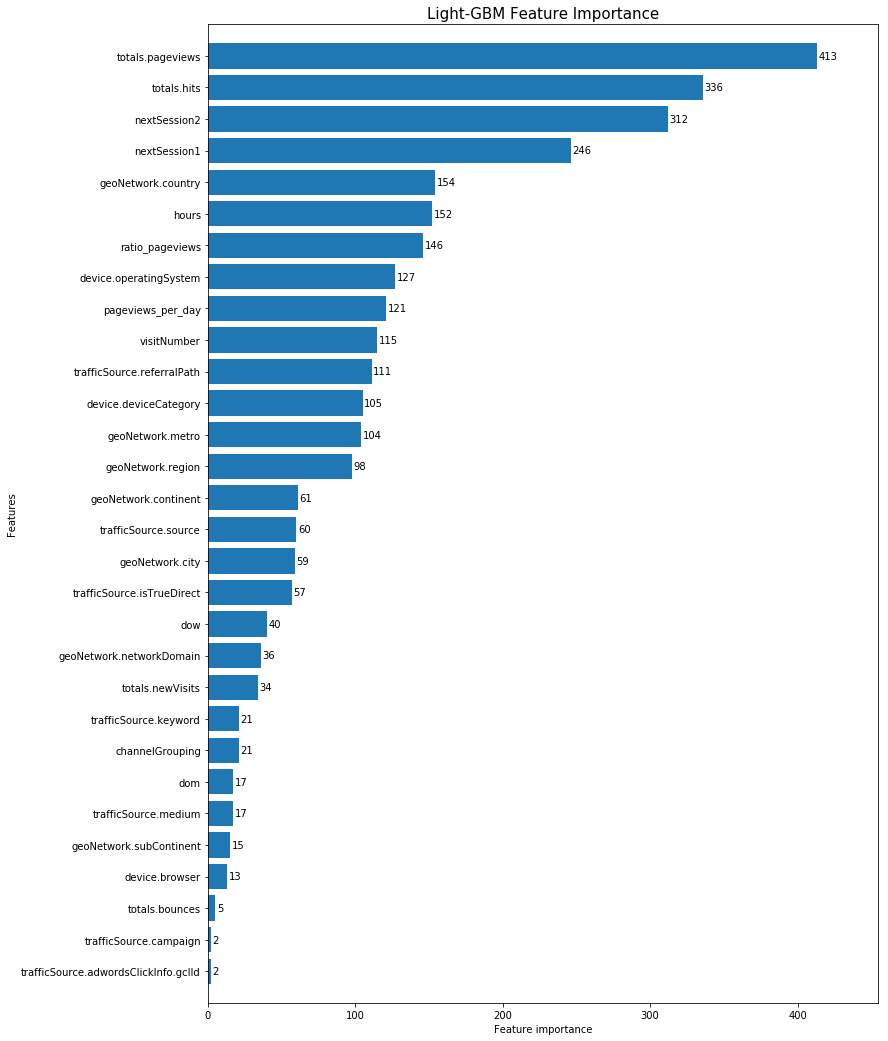

In [112]:
# visualize feature importance
fig, ax = plt.subplots(figsize=(12, 18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title('Light-GBM Feature Importance', fontsize=15)

In [49]:
pred_dev = pd.DataFrame()
pred_dev[['fullVisitorId', 'totals.transactionRevenue']] = train_df[['fullVisitorId', 'totals.transactionRevenue']]
pred_dev['predRevenue'] = np.expm1(oof_pred)

In [50]:
rmse(np.log1p(pred_dev['totals.transactionRevenue']), np.log1p(pred_dev['predRevenue']))

1.5942395372520661

In [52]:
pred_dev = pred_dev.groupby('fullVisitorId')[['totals.transactionRevenue', 'predRevenue']].sum().reset_index()

In [53]:
rmse(np.log1p(pred_dev['totals.transactionRevenue']), np.log1p(pred_dev['predRevenue']))

1.595345450974619

In [54]:
len(pred_dev)

714167

In [99]:
submission = pd.read_csv('sample_submission.csv')
test_id = test_df['fullVisitorId'].values
pred_test_df = pd.DataFrame({'fullVisitorID': test_id})
pred_test_df['predict'] = test_pred
pred_test_df = pred_test_df.groupby('fullVisitorID')['predict'].sum().reset_index()
pred_test_df['predict'] = np.log1p(pred_test_df['predict'].values)

submission = submission.merge(pred_test_df, left_on='fullVisitorId', right_on='fullVisitorID')
submission =submission.drop(['PredictedLogRevenue', 'fullVisitorID'], axis=1)
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [100]:
submission.to_csv('lgb_submission.csv', index=0)

In [130]:
train_df['channelGrouping']

0         Organic Search
1         Organic Search
2         Organic Search
3         Organic Search
4         Organic Search
5         Organic Search
6         Organic Search
7         Organic Search
8         Organic Search
9         Organic Search
10        Organic Search
11        Organic Search
12        Organic Search
13        Organic Search
14        Organic Search
15        Organic Search
16        Organic Search
17        Organic Search
18        Organic Search
19        Organic Search
20        Organic Search
21        Organic Search
22        Organic Search
23        Organic Search
24        Organic Search
25        Organic Search
26        Organic Search
27        Organic Search
28              Referral
29        Organic Search
               ...      
903623            Social
903624            Social
903625            Social
903626            Social
903627            Social
903628            Social
903629            Social
903630            Social
903631            Social
